In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/yermaand/audio-nn'

In [3]:
from glob import glob
import os
import shutil
import subprocess
from src import *
import matplotlib.pyplot as plt
import scipy.signal as S

No module named 'gurobipy'


In [10]:
def plot_alignment(signals, ax=plt, sr=44100, each=100, from_time=0, till_time=60*3):
    from_sample = int(sr * from_time)
    till_sample = int(sr * till_time)
    if ax == plt:
        ax.figure(figsize=(20, 10))
    for signal in signals:
        ax.plot(signal[from_sample:till_sample:each], alpha=0.5)

def align_signals(reference, target, sr=44100):
    corr = S.correlate(reference, target)
    lags = S.correlation_lags(len(reference), len(target))

    for arg in corr.argsort()[::-1][:100]:
        print(f'lag: {lags[arg] / sr:.2f} [s] with correlation {corr[arg]:.2f}')

    lag = lags[corr.argmax()]
    print(f'lag: {lag / sr:.2f} [s]')
    
    if lag > 0:
        return torch.cat([torch.zeros(lag), target[:-lag]])
    else:
        lag = abs(lag)
        # return torch.cat([target[lag:], torch.zeros(lag)])
        return target[lag:]

# Part I

In [5]:
files = load_files_from_dataset('014_eyedea_september_RX100')
files_all = load_files_from_dataset('014_eyedea_september')

In [6]:
alignmnemt_dict = {k: [] for k in files}

for k, v in alignmnemt_dict.items():
    for file_path in files_all:
        file_name = file_path.split('/')[-1].split('.')[0]
        if file_name[:2] == k[:2] and file_name != k and file_name not in alignmnemt_dict[k]:
            alignmnemt_dict[k].append(file_name)
    print(f'{k}: {alignmnemt_dict[k]}')

62_RX100: ['62_Mobius', '62_Samsung']
63_RX100: ['63_Mobius', '63_Samsung']
64_RX100: ['64_Mobius', '64_Samsung']
65_RX100: ['65_Samsung']
66_RX100: ['66_Samsung']
67_RX100: ['67_Samsung']
68_RX100: ['68_Mobius', '68_Samsung']
69_RX100: ['69_Mobius', '69_Samsung']
70_RX100: ['70_Mobius', '70_Samsung']
71_RX100: ['71_Mobius', '71_Samsung']


### Example

In [12]:
# example
# load wav files
signal_1, sr = load_audio('32_Cementarska_RX100', return_sr=True)
signal_2 = load_audio('32_Cementarska_Mobius')
signal_3 = load_audio('32_Cementarska_iphone')

# align 
signal_2_aligned = align_signals(signal_1, signal_2)
signal_3_aligned = align_signals(signal_1, signal_3)

# show
fig, axes = plt.subplots(2, figsize=(20, 10))
plot_alignment([signal_1, signal_2, signal_3], ax=axes[0])
plot_alignment([signal_1, signal_2_aligned, signal_3_aligned], ax=axes[1])
plt.tight_layout() 

# save
# torch.save([signal_1, sr], 'data/audio_tensors/12_RX100.MP4.pt')
# torch.save([signal_2_aligned, sr], 'data/audio_tensors/12_iphone.MP4.pt')
# torch.save([signal_3_aligned, sr], 'data/audio_tensors/12_Mobius.MP4.pt')

KeyboardInterrupt: 

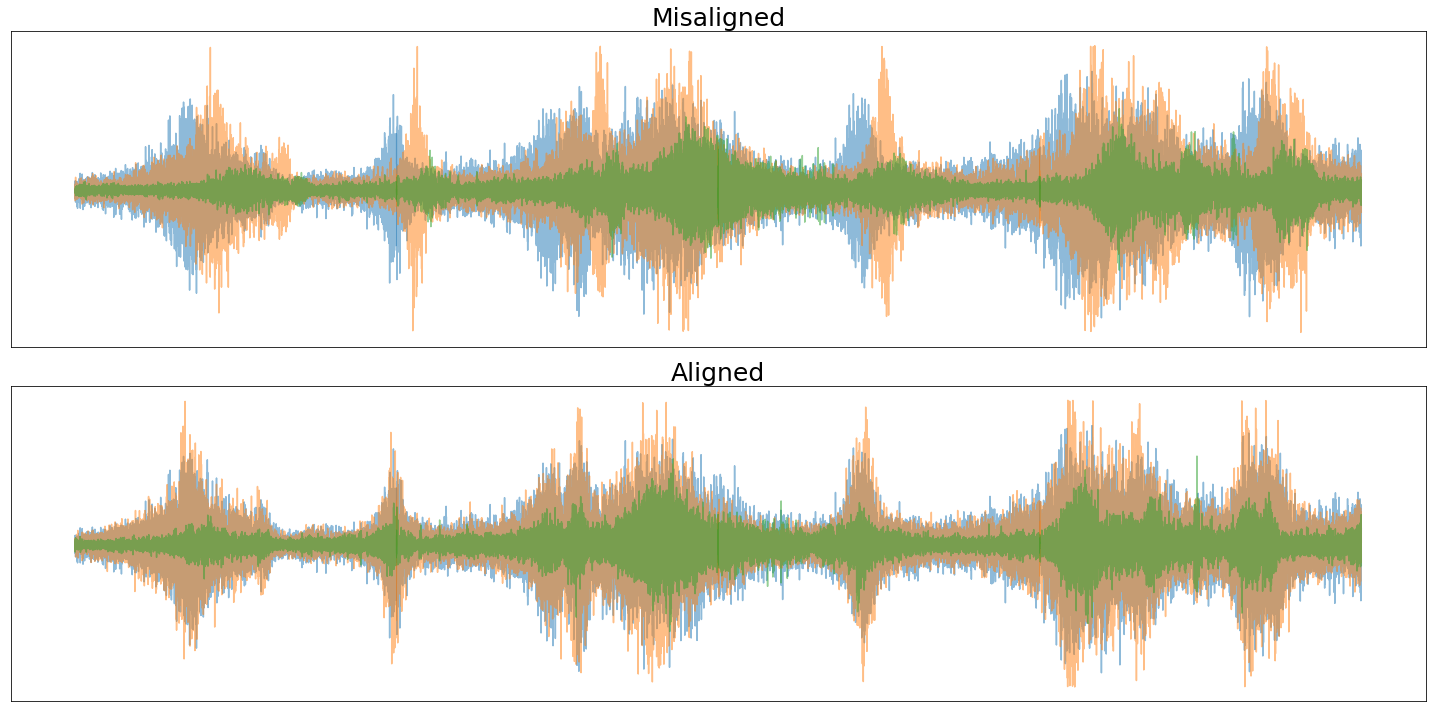

In [12]:
fig, axes = plt.subplots(2, figsize=(20, 10))

from_time = 60
till_time = 60 * 2 + 15
plot_alignment([signal_1, signal_2, signal_3], from_time=from_time, till_time=till_time, ax=axes[0])
plot_alignment([signal_1, signal_2_aligned, signal_3_aligned], from_time=from_time, till_time=till_time, ax=axes[1])
for ax in axes:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
axes[0].set_title('Misaligned', fontsize=25)
axes[1].set_title('Aligned', fontsize=25)
plt.tight_layout()
plt.savefig('plots/aligned_signals.png', dpi=150)

In [11]:
get_signal_length(signal_1, sr), get_signal_length(signal_2, sr), get_signal_length(signal_3, sr)

(1236, 1232, 1235)

### Cycle

In [16]:
subfolder = 'eyedea_aligned'
reference_camera_name = 'RX100'


reference: 62_RX100
target: 62_Mobius
lag: 1.42 [s]
aligned signal length: 1399 [s]
target: 62_Samsung
lag: -0.04 [s]
aligned signal length: 1399 [s]

reference: 63_RX100
target: 63_Mobius
lag: 2.91 [s]
aligned signal length: 1399 [s]
target: 63_Samsung
lag: 0.52 [s]
aligned signal length: 1398 [s]

reference: 64_RX100
target: 64_Mobius
lag: -1.96 [s]
aligned signal length: 1402 [s]
target: 64_Samsung
lag: -1.91 [s]
aligned signal length: 1403 [s]

reference: 65_RX100
target: 65_Samsung
lag: 10.05 [s]
aligned signal length: 1253 [s]

reference: 66_RX100
target: 66_Samsung
lag: -0.83 [s]
aligned signal length: 1204 [s]

reference: 67_RX100
target: 67_Samsung
lag: -1.14 [s]
aligned signal length: 1212 [s]

reference: 68_RX100
target: 68_Mobius
lag: -1.10 [s]
aligned signal length: 1302 [s]
target: 68_Samsung
lag: -0.91 [s]
aligned signal length: 1306 [s]

reference: 69_RX100
target: 69_Mobius
lag: -0.98 [s]
aligned signal length: 1225 [s]
target: 69_Samsung
lag: -22.47 [s]
aligned signa

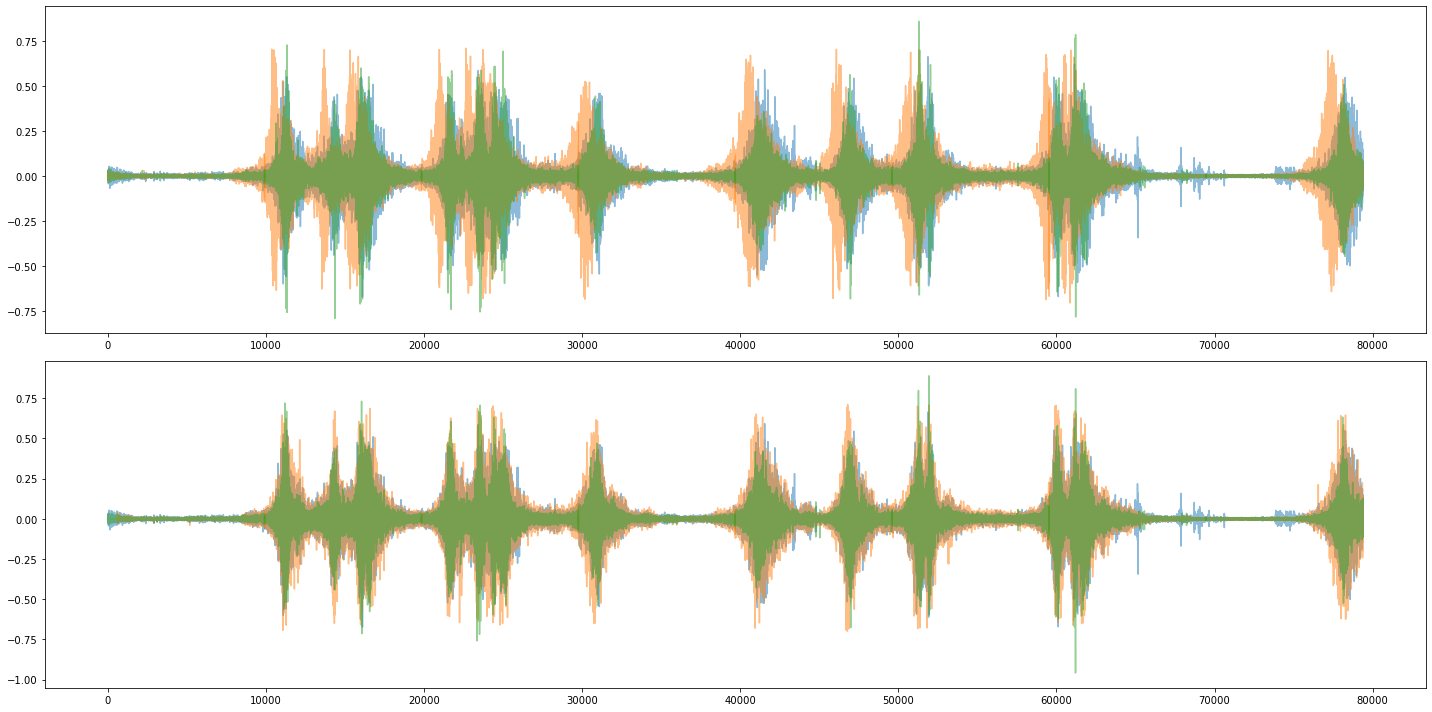

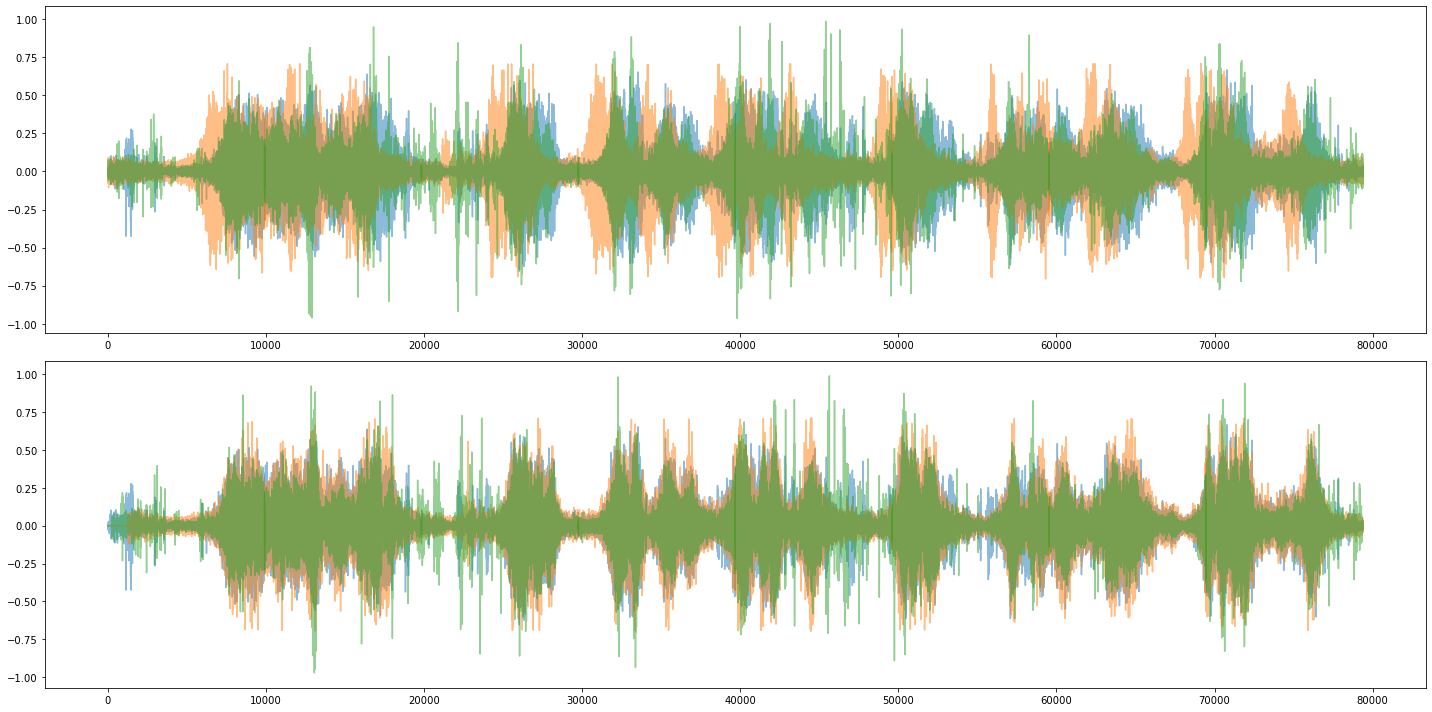

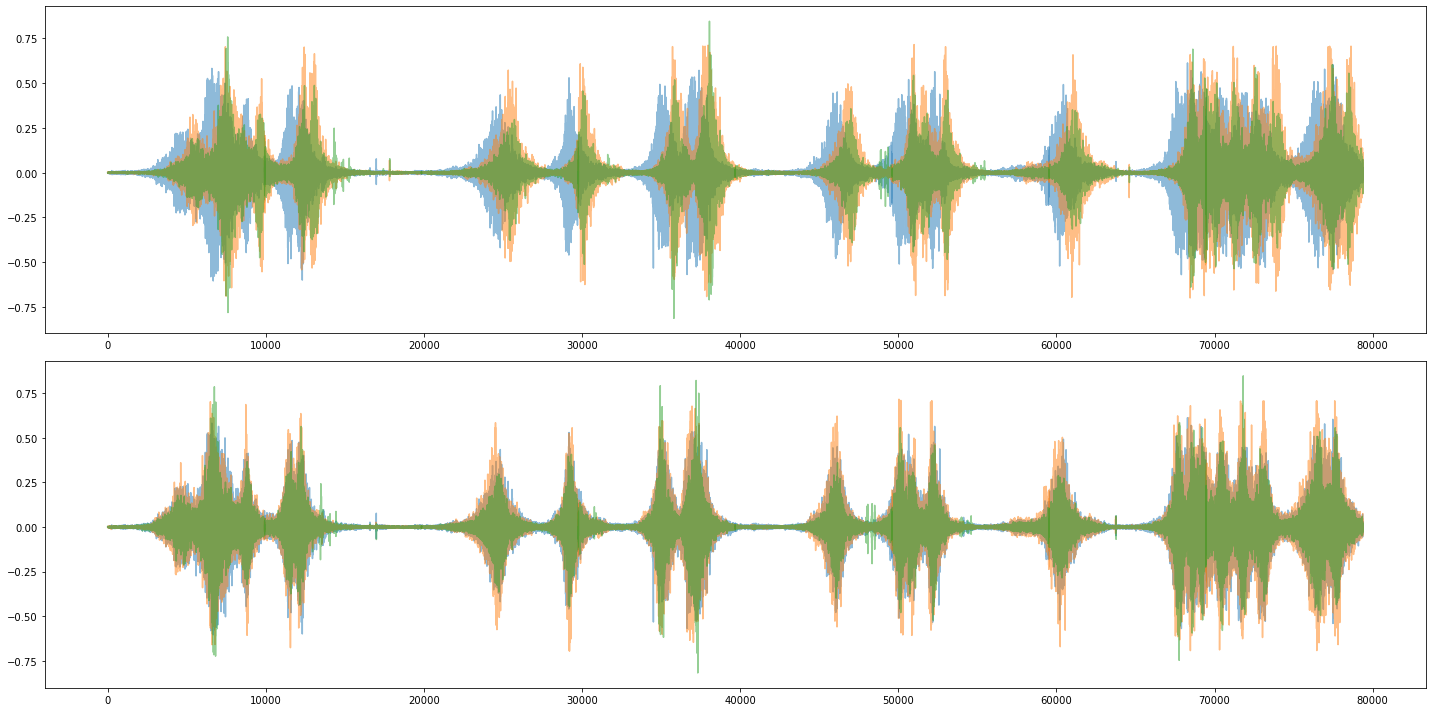

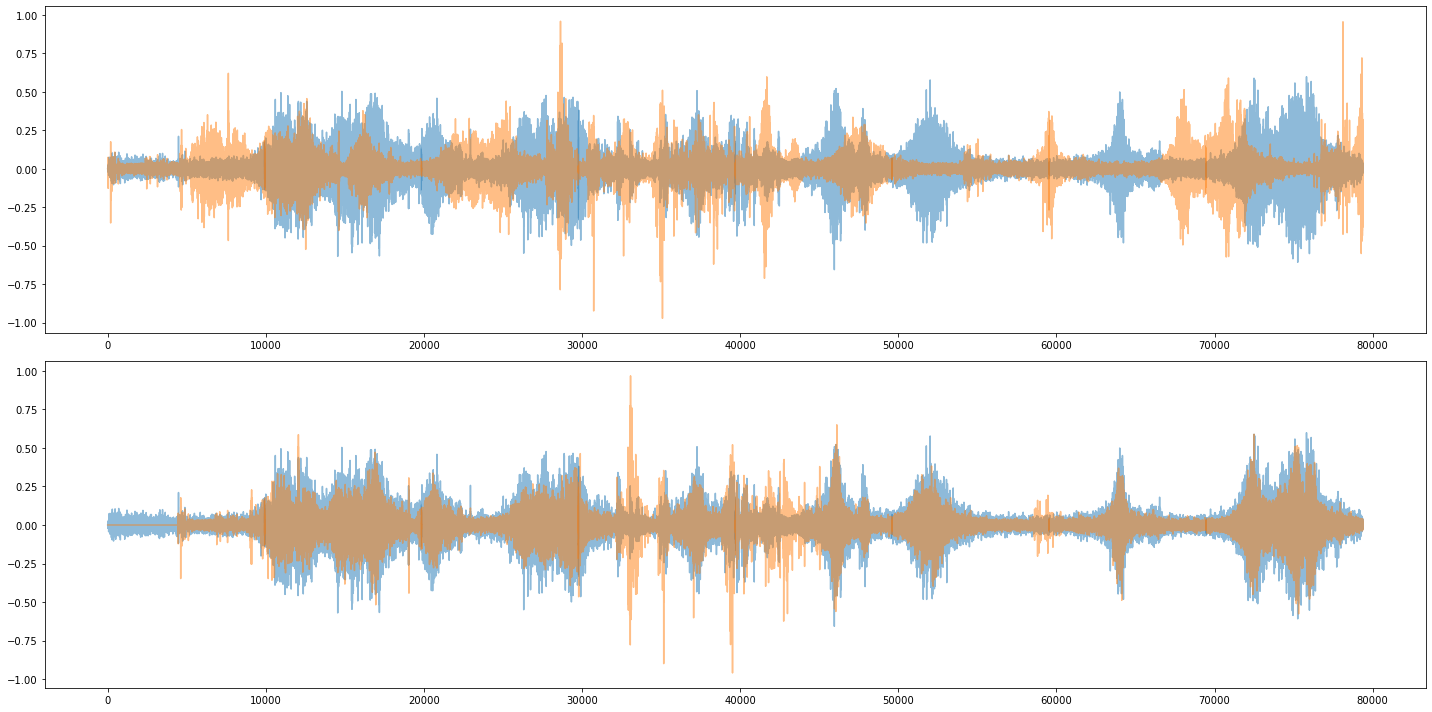

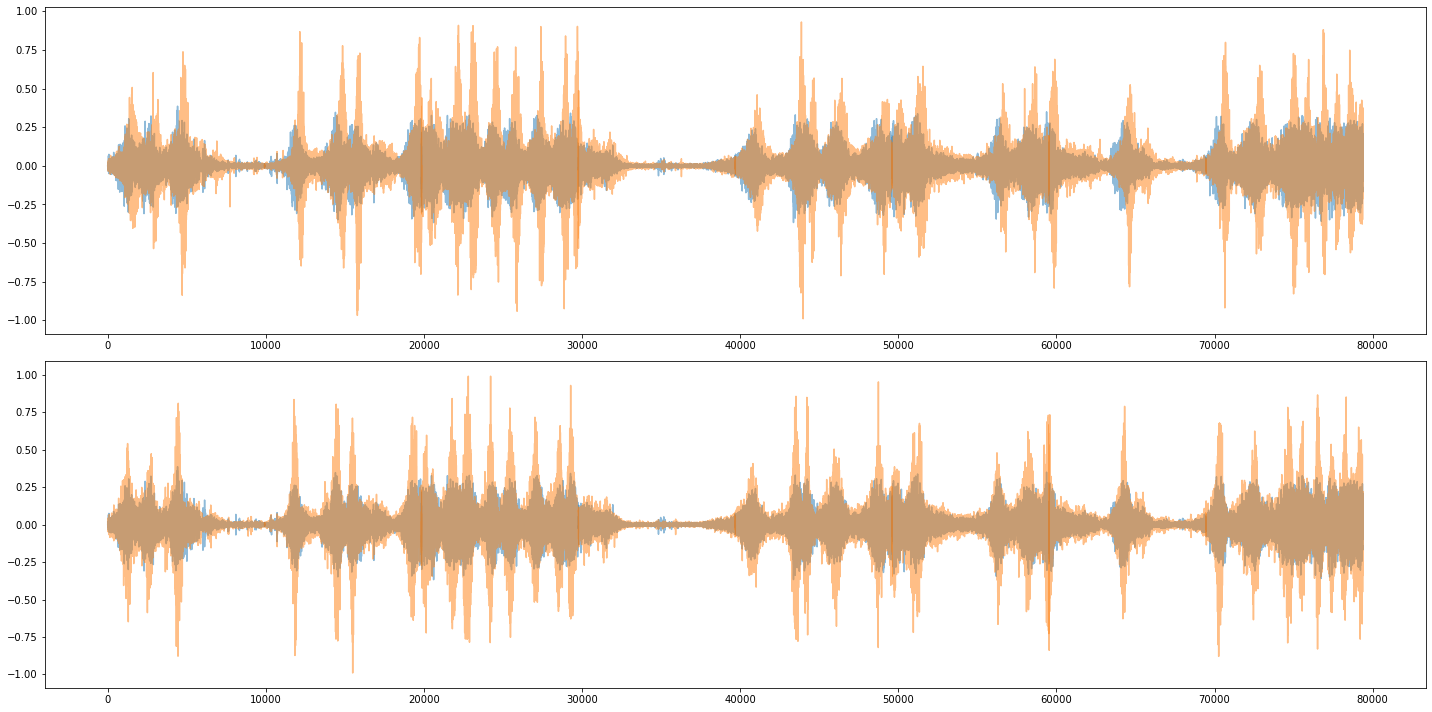

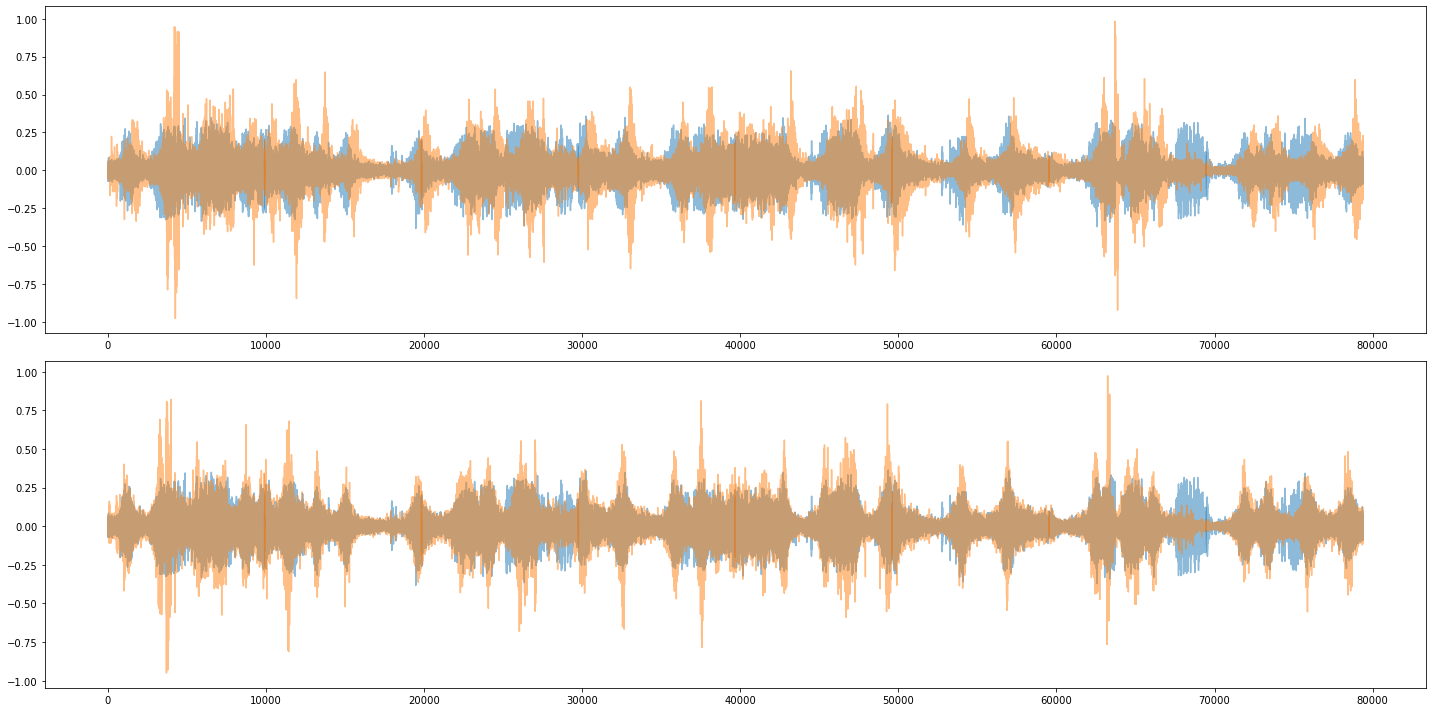

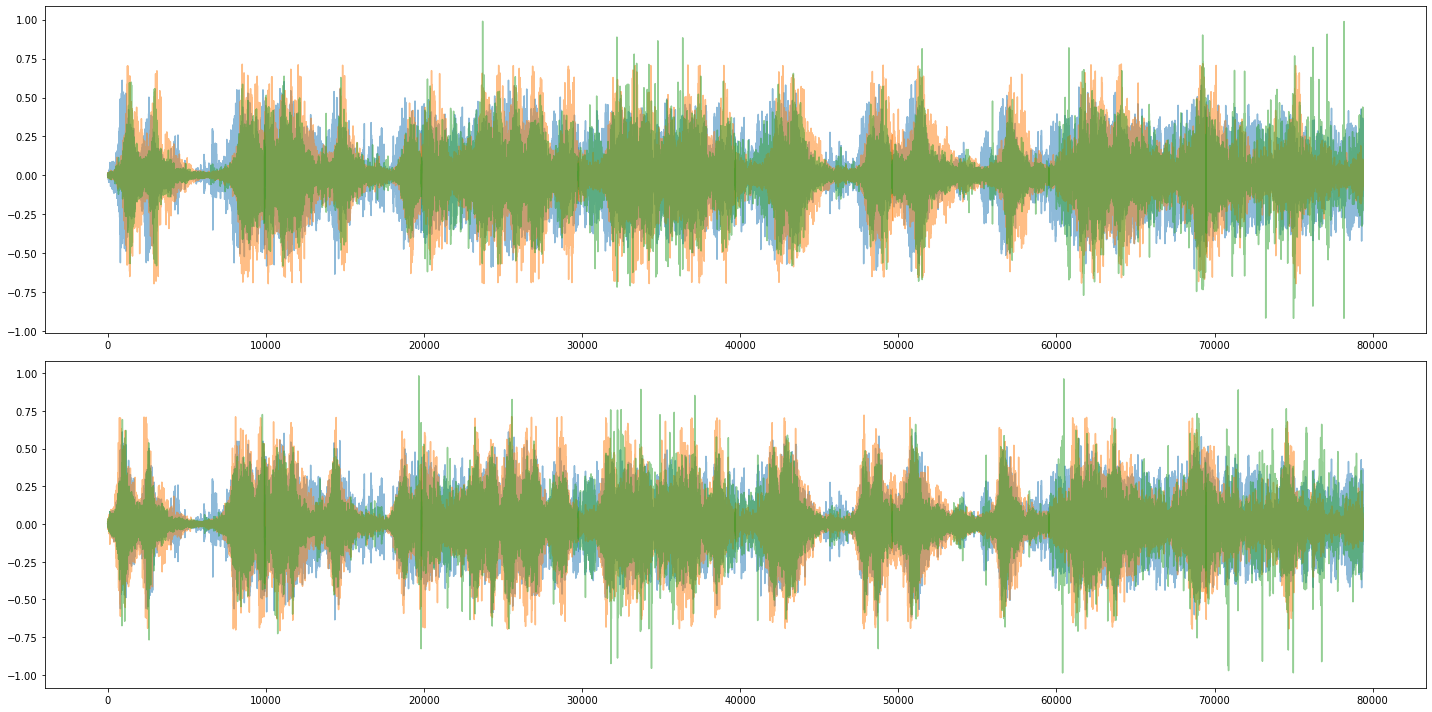

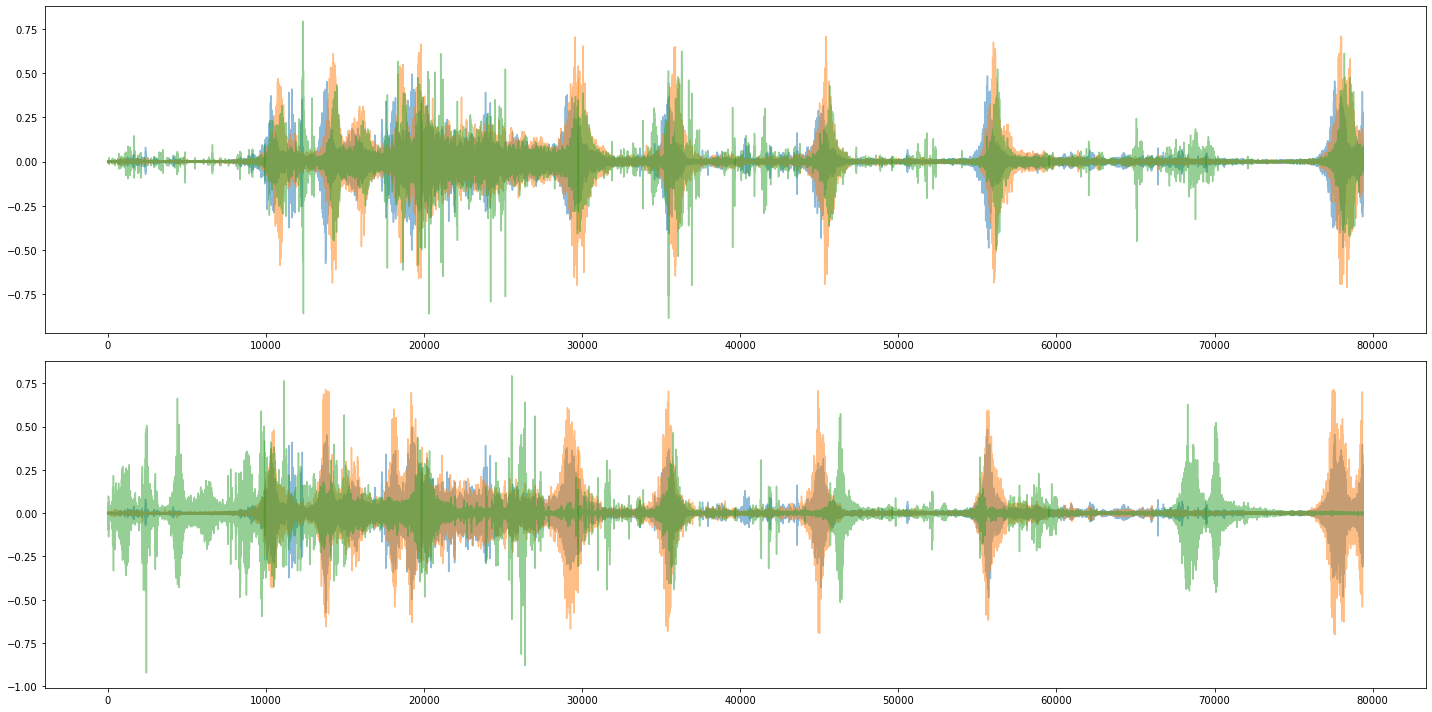

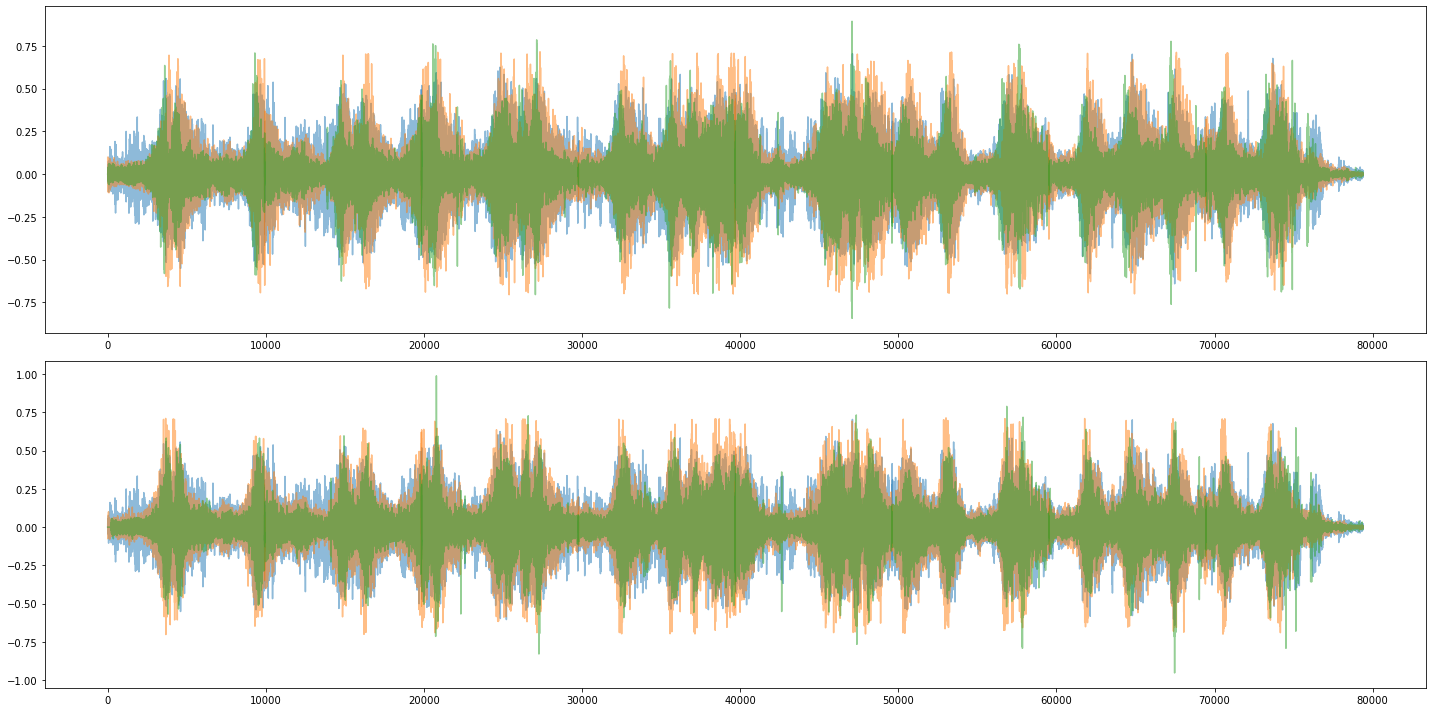

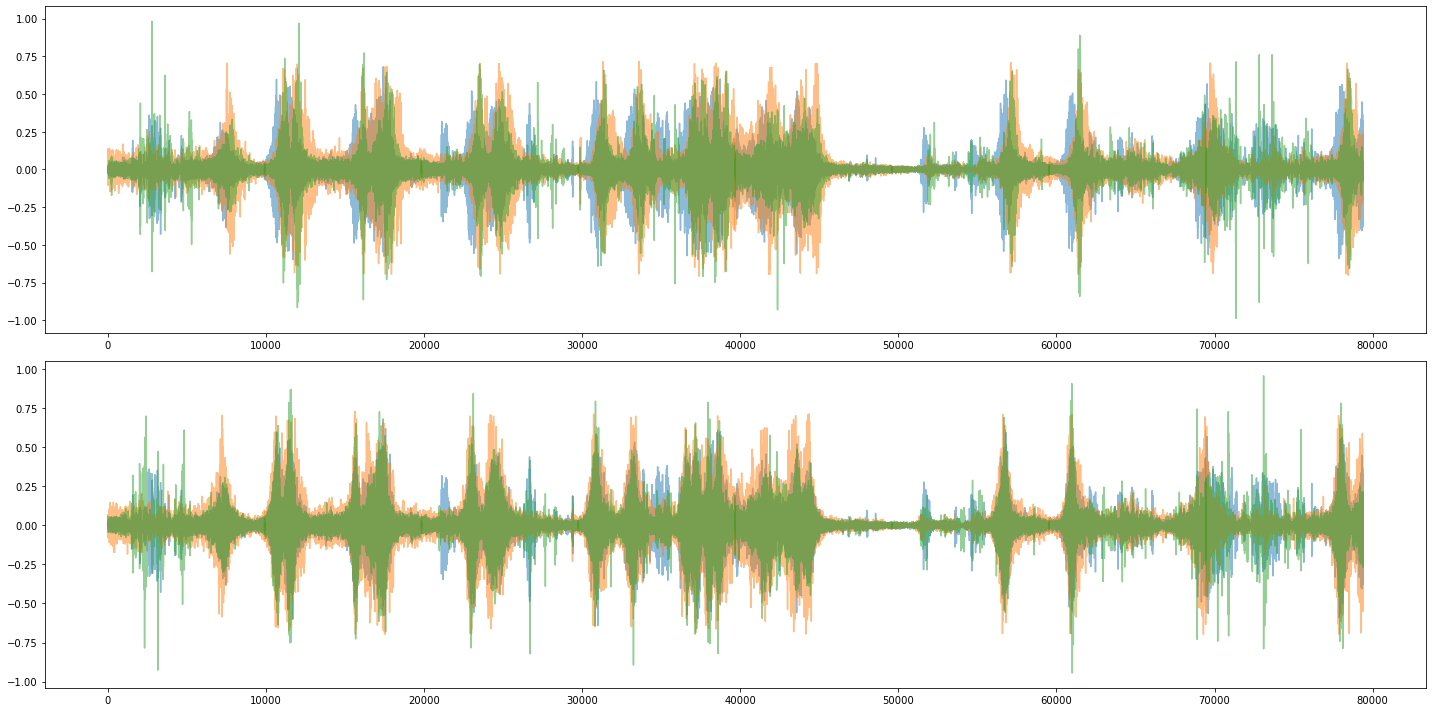

In [8]:
os.makedirs(f'data/audio_pt/{subfolder}', exist_ok=True)
os.makedirs(f'data/csv/{subfolder}', exist_ok=True)

for reference_name, targets in alignmnemt_dict.items():
    print(f'\nreference: {reference_name}')

    # load reference signal
    reference_signal, sr = load_audio(reference_name, return_sr=True)
    
    signals = [reference_signal]
    signals_aligned = [reference_signal]
    for target_name in targets:
        print(f'target: {target_name}')
        
        # load target signal
        target_signal = load_audio_wav(f'data/audio_wav/{target_name}.wav')
        signals.append(target_signal)

        # align reference and target signals
        aligned_signal = align_signals(reference_signal, target_signal)
        signals_aligned.append(aligned_signal)

        print(f'aligned signal length: {get_signal_length(aligned_signal, sr)} [s]')

        # save aligned target signal
        audio_pt = f'data/audio_pt/{subfolder}/{target_name}_aligned_{reference_camera_name}.pt'
        if not os.path.exists(audio_pt):
            torch.save([aligned_signal, sr], audio_pt)
        
        # save csv
        csv_reference = find_csv(reference_name)
        csv_target = f'data/csv/{subfolder}/{target_name}_aligned_{reference_camera_name}.csv'
        if not os.path.exists(csv_target):
            shutil.copy2(csv_reference, csv_target)

    plt_path = f'plots/alignments/{reference_name}.png'
    fig, axes = plt.subplots(2, figsize=(20, 10))
    plot_alignment(signals, ax=axes[0])
    plot_alignment(signals_aligned, ax=axes[1])
    plt.tight_layout()
    plt.savefig(plt_path)


In [17]:
DATASET = '014_eyedea_september'

files_to_preprocess = []
for f in load_dataset(DATASET):
    if reference_camera_name not in f[0]:
        f[0] += f'_aligned_{reference_camera_name}'
        files_to_preprocess.append(f)

files_to_preprocess

[['62_Mobius_aligned_RX100', 1],
 ['62_Samsung_aligned_RX100', 1],
 ['63_Mobius_aligned_RX100', 1],
 ['63_Samsung_aligned_RX100', 1],
 ['64_Mobius_aligned_RX100', 1],
 ['64_Samsung_aligned_RX100', 1],
 ['65_Samsung_aligned_RX100', 1],
 ['66_Samsung_aligned_RX100', 1],
 ['67_Samsung_aligned_RX100', 1],
 ['68_Mobius_aligned_RX100', 1],
 ['68_Samsung_aligned_RX100', 1],
 ['69_Mobius_aligned_RX100', 1],
 ['70_Mobius_aligned_RX100', 1],
 ['70_Samsung_aligned_RX100', 1],
 ['71_Mobius_aligned_RX100', 1],
 ['71_Samsung_aligned_RX100', 1]]

In [18]:
OUTPUT_DATASET = '014_eyedea_september_aligned_RX100'

aligned_yaml_dataset = []
for f in load_dataset(DATASET):
    # f[0] = '- '+ f[0]
    if reference_camera_name not in f[0]:
        f[0] += f'_aligned_{reference_camera_name}'
        aligned_yaml_dataset.append(f)
    else:
        aligned_yaml_dataset.append(f)

aligned_yaml_dataset

import yaml

with open(f'config/dataset/{OUTPUT_DATASET}.yaml', 'w') as yaml_file:
    yaml.dump(aligned_yaml_dataset, yaml_file, default_flow_style=None)

In [20]:
from preprocess_data import preprocess

preprocess(files_to_preprocess)

--------------------------------------------------
File:  62_Mobius_aligned_RX100

Extracting audio
[green]file data/audio_pt/eyedea_aligned/62_Mobius_aligned_RX100.pt exists

Extracting labels
signal_length: 1399
62_Mobius_aligned_RX100: 1.35, 0.55
[green]saving labels to data/labels//62_Mobius_aligned_RX100.txt

Extracting intervals
[green]saving intervals to data/intervals//62_Mobius_aligned_RX100.txt
--------------------------------------------------
File:  62_Samsung_aligned_RX100

Extracting audio
[green]file data/audio_pt/eyedea_aligned/62_Samsung_aligned_RX100.pt exists

Extracting labels
signal_length: 1399
62_Samsung_aligned_RX100: 1.15, 0.65
[green]saving labels to data/labels//62_Samsung_aligned_RX100.txt

Extracting intervals
[green]saving intervals to data/intervals//62_Samsung_aligned_RX100.txt
--------------------------------------------------
File:  63_Mobius_aligned_RX100

Extracting audio
[green]file data/audio_pt/eyedea_aligned/63_Mobius_aligned_RX100.pt exists

Ext

In [8]:
# from preprocess_data import preprocess

# files_to_preprocess = []
# for v in alignmnemt_dict.values():
#     files_to_preprocess.extend(v)
# files_to_preprocess = [f'{name}_aligned' for name in files_to_preprocess]
# preprocess(files_to_preprocess)

# files_to_preprocess = list(alignmnemt_dict.keys())
# preprocess(files_to_preprocess)

--------------------------------------------------
File:  01_Vypadova_A41

Extracting audio
file data/audio_tensors/01_Vypadova_A41.MP4.pt exists

Extracting labels
01_Vypadova_A41: 0.95, 0.55

Extracting intervals
data/labels/01_Vypadova_A41.MP4.txt 9
--------------------------------------------------
File:  03_KPrehradam_A6000

Extracting audio
file data/audio_tensors/03_KPrehradam_A6000.MP4.pt exists

Extracting labels
03_KPrehradam_A6000: 2.15, 0.45

Extracting intervals
data/labels/03_KPrehradam_A6000.MP4.txt 23
--------------------------------------------------
File:  05_RX100

Extracting audio
file data/audio_tensors/05_RX100.MP4.pt exists

Extracting labels
05_RX100: 1.35, 1.15

Extracting intervals
data/labels/05_RX100.MP4.txt 32
--------------------------------------------------
File:  06_RX100

Extracting audio
file data/audio_tensors/06_RX100.MP4.pt exists

Extracting labels
06_RX100: 1.55, 0.85

Extracting intervals
data/labels/06_RX100.MP4.txt 34
-------------------------

# Part II

In [ ]:
config = Config()
config.normalization = 'global'
transformation = create_transformation(config)

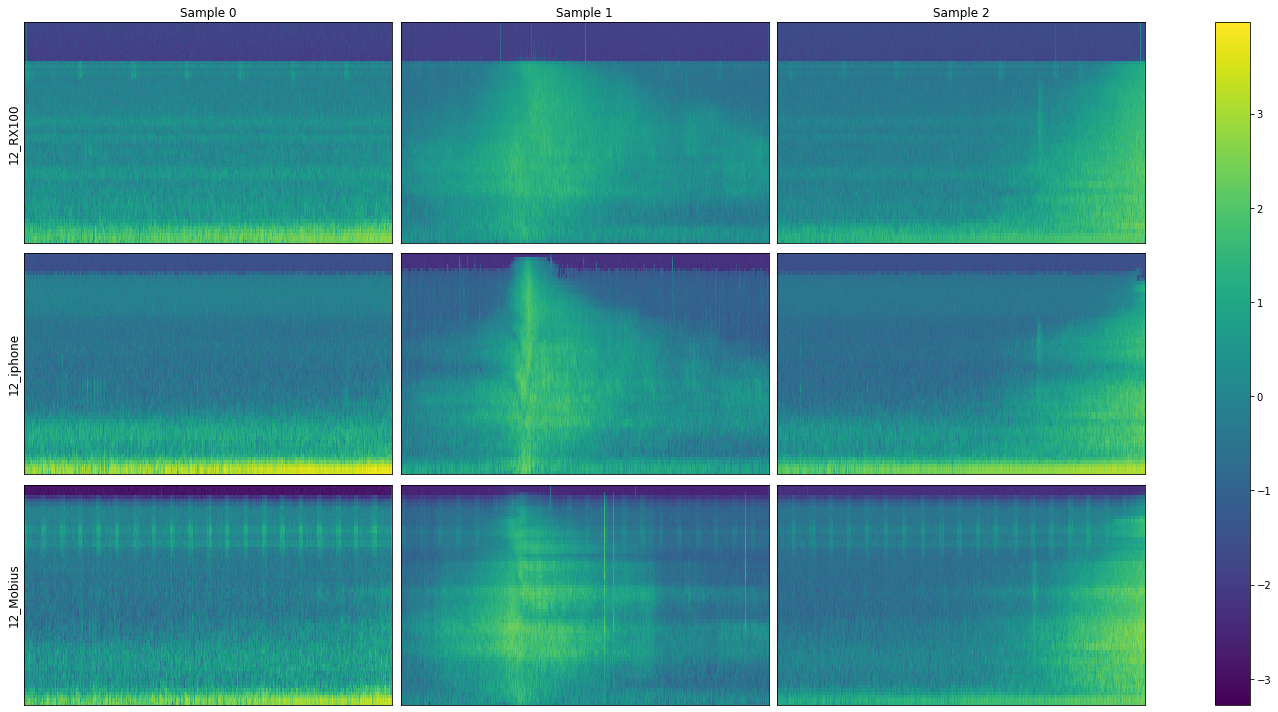

In [ ]:
n_domains = 3
n_samples = 3

s1, sr1 = torch.load('data/audio_tensors/12_RX100.MP4.pt')
s2, sr2 = torch.load('data/audio_tensors/12_iphone.MP4.pt')
s3, sr3 = torch.load('data/audio_tensors/12_Mobius.MP4.pt')

vmin = np.inf
vmax = -np.inf

features = defaultdict(list)

for i in range(n_samples):
    f_i = int(np.random.choice(len(s1)))
    f_j = int(f_i + 20 * sr1)
    
    for s in [s1, s2, s3]:
        X = s[f_i: f_j]
        X = transformation(X).squeeze()
        vmin = min(X.min(), vmin)
        vmax = max(X.max(), vmax)
        features[i].append(X)

fig, axes = plt.subplots(n_samples, n_domains, figsize=(20, 10))

for i in range(n_samples):
    for j in range(n_domains):
        ax = axes[i, j]
        im = ax.pcolormesh(features[j][i], vmin=vmin, vmax=vmax)
        
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

cols = [f'Sample {i}' for i in range(n_samples)]
rows = ['12_RX100', '12_iphone', '12_Mobius']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, size='large')
    
plt.tight_layout()
fig.colorbar(im, ax=axes.tolist());